## CSML1010 Group3 Course_Project - Milestone 1 - Feature Engineering and Selection
#### Authors (Group3): Paul Doucet, Jerry Khidaroo
#### Project Repository: https://github.com/CSML1010-3-2020/NLPCourseProject

#### Dataset:
The dataset used in this project is the __Taskmaster-1__ dataset from Google.
[Taskmaster-1](https://research.google/tools/datasets/taskmaster-1/)

The dataset can be obtained from: https://github.com/google-research-datasets/Taskmaster

#### Import Libraries

In [1]:
# import pandas, numpy
import pandas as pd
import numpy as np
import re
import nltk


#### Set Some Defaults

In [2]:
# adjust pandas display
pd.options.display.max_columns = 30
pd.options.display.max_rows = 100
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.precision = 2
pd.options.display.max_colwidth = None

# Import matplotlib and seaborn and adjust some defaults
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from matplotlib import pyplot as plt
plt.rcParams['figure.dpi'] = 100

import seaborn as sns
sns.set_style("whitegrid")

## 1. Data Preparation

#### Load Data

In [3]:
import sqlite3

sql = """
SELECT p.*
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df = pd.read_sql_query(sql, con)

#### Get relevant columns

In [4]:
sql = """
SELECT p.selfdialog_clean, p.instruction_id
FROM posts_nlp p
"""

with sqlite3.connect('selfdialogs.db') as con:
    df_all = pd.read_sql_query(sql, con)

Down sample to 1000 records.

In [5]:
print ((1000 * 1000)//7708)

129


In [6]:
# Get 50 per instruction_id then reduce to 1000
def sampling_k_elements(group, k=130):
    if len(group) < k:
        return group
    return group.sample(k)

#Get balanced samples
corpus_df = df_all.groupby('Instruction_id').apply(sampling_k_elements).reset_index(drop=True)

#Reduce to 1000
corpus_df = corpus_df.sample(n=1000, random_state=1)
print (corpus_df.groupby('Instruction_id').size())

Instruction_id
auto-repair-appt-1    78
coffee-ordering-1     73
coffee-ordering-2     79
movie-finder          36
movie-tickets-1       80
movie-tickets-2       79
movie-tickets-3       76
pizza-ordering-1      70
pizza-ordering-2      81
restaurant-table-1    72
restaurant-table-2    73
restaurant-table-3    65
uber-lyft-1           71
uber-lyft-2           67
dtype: int64


#### Create Factorized 'category' column from 'Instruction_id' label column.

In [7]:
corpus_df['category'] = corpus_df['Instruction_id'].factorize()[0]
corpus_df.head(5)

,selfdialog_clean,Instruction_id,category
111,"Hey, I need an oil change. OK, I can help with that. When would you like to have that done? As soon as possible. OK, will this be for your truck, Phoebe's car, or another vehicle. My truck. Alright, we're looking at an oil change for your 2014 Toyota Tacoma, is this right? Yup. Are there any other issues that need to be addressed? Actually, it has a small oil leak that I'd like them to look for. Ok, I'll add that to the service request. Great, when can I get it done. Do you want to use Intelligent Auto Solutions again? You left them positive feedback last time. Yeah, that sounds good. I like them. OK, the first available appointment is tomorrow at 1500 hours. Would you like me to book that time slot? No, I need something earlier. What are my other options? Intelligent Auto Solutions says you may drop the vehicle off in the morning, or I can look for an appointment at another location. Craig's Garage is 1.2 miles further away and has a rating of 3.9 stars No, I'll just drop it off in the morning. OK, I am setting up your repair request with Intelligent Auto Solutions for your 2014 Toyota Tacoma for an oil change and leak inspection. That is $120 total for the oil change and inspection. Shall I go ahead and submit? Yeah, that all sounds fine. OK, confirming your work request has been submitted, and Intelligent Auto Solutions is expecting your truck tomorrow morning. Is there anything else I can assist you with? Nope, that'll do, assistant. That'll do.",auto-repair-appt-1,0
126,"Hi, I need to schedule an appointment with an auto mechanic. Hi, what mechanic would you like to use? Intelligent Auto Solutions on 300 Main Street in Boston Alright. What make and model of car? 2005 Jeep Grand Cherokee Limited Alright. What seems to be the problem with the vehicle? It makes a loud clunking sound when it shifts. Great. What day and time do you want the appointment? As soon as possible. Okay. Let me check to see if they have availability. Thank you. You're welcome. Just give me a moment. Sure. I can schedule an appointment for 3 pm tomorrow April 13th. Does that work for you? Yep. Okay, I just need some more information. Okay. What is your name and phone number? My name is Jeff and my personal line is 555-233-1663 Great. I will schedule the appointment and have the details sent to your phone.",auto-repair-appt-1,0
555,"Hi, I'd like to get tickets for Bohemian Rhapsody. Ok.. what town? Conway Arkansas Ok.. In Conway Arkansas Bohemian Rhapsody is playing at Cinemarks Cinema 6 Ok.. What are tonight's times? There are showings at 5:05, 7:25, and 10 p.m. How much are tickets at the 5:05 showing? Those are Matinee Price - They cost 5.00 each. Ok.. That's what I want. How many tickets? 3 Ok.. got it. Can you have the tickets sent to my cell phone app? Yes Can you find out if the crowds are large for that time of day? Yes, I'll search for that information. Thanks There is no mention on social media regarding this.. chances are the crowds for that time of day are normal. Today isn't a special discount day. Ok. Thank you. The charge 0f 15.00 will appear on your receipt. Great thanks.",movie-tickets-1,1
1260,"I would like authentic cuisine from another country- not typical American ""burgers 'n fries"" meal. . Oh, how about the delicious and renowned Mexican restaurant Vaya con Dios? They have a beautiful patio too. Ah! Sounds amazing! Or Tataya's Thai is a popular spot with a fresh interior and a hip feel. So hard to choose! I think I would recommend Vaya con Dios, it is very elegant and sophisticated. Perfect spot for a beautiful night. Perfect. I'd like a reservation for this Friday evening at 7 pm, with my husband, and to sit outside. OK, let me check for you, Madam, since I am your invaluable assistant. Indeed you are, I value your very presence. Ah, unfortunately they do not have any availability at that time. Oh gosh, what a shame. How about 8 pm? Yes, 8 is better anyway, cooler weather. Then I ca

#### Word Embeddings

In [8]:
df.columns

Index(['index', 'id', 'Conversation', 'Instruction_id', 'service_type',
       'selfdialog_clean', 'selfdialog_lemma', 'selfdialog_nouns',
       'selfdialog_adjectives', 'selfdialog_verbs', 'selfdialog_nav',
       'no_tokens'],
      dtype='object')

In [9]:
corpus_df.columns

Index(['selfdialog_clean', 'Instruction_id', 'category'], dtype='object')

#### Do Some Additional CLeaning

In [10]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    #doc = "'" + doc + "'"
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    #doc = [[word.lower() for word in sent if word not in remove_terms] for sent in doc]
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    
    return doc

normalize_corpus = np.vectorize(normalize_document)

In [11]:
for i, row in corpus_df.iterrows():
    corpus_df.at[i, "selfdialog_norm"] = normalize_corpus(row.selfdialog_clean) 

corpus_df.head(3)

,selfdialog_clean,Instruction_id,category,selfdialog_norm
111,"Hey, I need an oil change. OK, I can help with that. When would you like to have that done? As soon as possible. OK, will this be for your truck, Phoebe's car, or another vehicle. My truck. Alright, we're looking at an oil change for your 2014 Toyota Tacoma, is this right? Yup. Are there any other issues that need to be addressed? Actually, it has a small oil leak that I'd like them to look for. Ok, I'll add that to the service request. Great, when can I get it done. Do you want to use Intelligent Auto Solutions again? You left them positive feedback last time. Yeah, that sounds good. I like them. OK, the first available appointment is tomorrow at 1500 hours. Would you like me to book that time slot? No, I need something earlier. What are my other options? Intelligent Auto Solutions says you may drop the vehicle off in the morning, or I can look for an appointment at another location. Craig's Garage is 1.2 miles further away and has a rating of 3.9 stars No, I'll just drop it off in the morning. OK, I am setting up your repair request with Intelligent Auto Solutions for your 2014 Toyota Tacoma for an oil change and leak inspection. That is $120 total for the oil change and inspection. Shall I go ahead and submit? Yeah, that all sounds fine. OK, confirming your work request has been submitted, and Intelligent Auto Solutions is expecting your truck tomorrow morning. Is there anything else I can assist you with? Nope, that'll do, assistant. That'll do.",auto-repair-appt-1,0,hey need oil change ok help would like done soon possible ok truck phoebes car another vehicle truck alright looking oil change toyota tacoma right yup issues need addressed actually small oil leak id like look ok ill add service request great get done want use intelligent auto solutions left positive feedback last time yeah sounds good like ok first available appointment tomorrow hours would like book time slot need something earlier options intelligent auto solutions says may drop vehicle morning look appointment another location craigs garage miles away rating stars ill drop morning ok setting repair request intelligent auto solutions toyota tacoma oil change leak inspection total oil change inspection shall go ahead submit yeah sounds fine ok confirming work request submitted intelligent auto solutions expecting truck tomorrow morning anything else assist nope thatll assistant thatll
126,"Hi, I need to schedule an appointment with an auto mechanic. Hi, what mechanic would you like to use? Intelligent Auto Solutions on 300 Main Street in Boston Alright. What make and model of car? 2005 Jeep Grand Cherokee Limited Alright. What seems to be the problem with the vehicle? It makes a loud clunking sound when it shifts. Great. What day and time do you want the appointment? As soon as possible. Okay. Let me check to see if they have availability. Thank you. You're welcome. Just give me a moment. Sure. I can schedule an appointment for 3 pm tomorrow April 13th. Does that work for you? Yep. Okay, I just need some more information. Okay. What is your name and phone number? My name is Jeff and my personal line is 555-233-1663 Great. I will schedule the appointment and have the details sent to your phone.",auto-repair-appt-1,0,hi need schedule appointment auto mechanic hi mechanic would like use intelligent auto solutions main street boston alright make model car jeep grand cherokee limited alright seems problem vehicle makes loud clunking sound shifts great day time want appointment soon possible okay let check see availability thank youre welcome give moment sure schedule appointment pm tomorrow april th work yep okay need information okay name phone number name jeff personal line great schedule appointment details sent phone
555,"Hi, I'd like to get tickets for Bohemian Rhapsody. Ok.. what town? Conway Arkansas Ok.. In Conway Arkansas Bohemian Rhapsody is playing at Cinemarks Cinema 6 Ok.. What are tonig

In [12]:
doc_lst = []
for i, row in corpus_df.iterrows():
    doc_lst.append(row.selfdialog_norm.tolist())

print(len(doc_lst))
doc_lst[1:5]

1000


['hi need schedule appointment auto mechanic hi mechanic would like use intelligent auto solutions main street boston alright make model car jeep grand cherokee limited alright seems problem vehicle makes loud clunking sound shifts great day time want appointment soon possible okay let check see availability thank youre welcome give moment sure schedule appointment pm tomorrow april th work yep okay need information okay name phone number name jeff personal line great schedule appointment details sent phone',
 'hi id like get tickets bohemian rhapsody ok town conway arkansas ok conway arkansas bohemian rhapsody playing cinemarks cinema ok tonights times showings pm much tickets showing matinee price cost ok thats want many tickets ok got tickets sent cell phone app yes find crowds large time day yes ill search information thanks mention social media regarding chances crowds time day normal today isnt special discount day ok thank charge f appear receipt great thanks',
 'would like auth

#### Build Vocabulary

In [13]:
from keras.preprocessing import text
from keras.utils import np_utils
from keras.preprocessing import sequence

tokenizer = text.Tokenizer(lower=False)
tokenizer.fit_on_texts(doc_lst)
word2id = tokenizer.word_index

word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in doc_lst]

vocab_size = len(word2id)
embed_size = 100
window_size = 2

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Using TensorFlow backend.
Vocabulary Size: 5771
Vocabulary Sample: [('like', 1), ('would', 2), ('okay', 3), ('ok', 4), ('yes', 5), ('pm', 6), ('want', 7), ('order', 8), ('tickets', 9), ('please', 10)]


#### Build (context_words, target_word) pair generator

In [14]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [15]:
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['hey', 'need', 'change', 'ok'] -> Target (Y): oil
Context (X): ['need', 'oil', 'ok', 'help'] -> Target (Y): change
Context (X): ['oil', 'change', 'help', 'would'] -> Target (Y): ok
Context (X): ['change', 'ok', 'would', 'like'] -> Target (Y): help
Context (X): ['ok', 'help', 'like', 'done'] -> Target (Y): would
Context (X): ['help', 'would', 'done', 'soon'] -> Target (Y): like
Context (X): ['would', 'like', 'soon', 'possible'] -> Target (Y): done
Context (X): ['like', 'done', 'possible', 'ok'] -> Target (Y): soon
Context (X): ['done', 'soon', 'ok', 'truck'] -> Target (Y): possible
Context (X): ['soon', 'possible', 'truck', 'phoebes'] -> Target (Y): ok
Context (X): ['possible', 'ok', 'phoebes', 'car'] -> Target (Y): truck


#### Set up Dictionaries to Cross-Refrence 'Instruction_id' and its Factorized value 'category'

In [16]:
category_id_df = corpus_df[['Instruction_id', 'category']].drop_duplicates().sort_values('category')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category', 'Instruction_id']].values)

#### Split Data into Train and Test Sets

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(doc_lst, corpus_df['Instruction_id'], test_size=0.25, random_state = 0)

## Bag of Words Feature Extraction

In [52]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0., max_df=1., vocabulary=word2id)
cv_matrix = cv.fit_transform(doc_lst)
cv_matrix = cv_matrix.toarray()
cv_matrix

array([[0, 4, 2, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 1, 0, 0],
       [0, 1, 0, ..., 0, 1, 1],
       [0, 6, 5, ..., 0, 0, 0]], dtype=int64)

In [53]:
# get all unique words in the corpus
vocab = cv.get_feature_names()
# show document feature vectors
pd.DataFrame(cv_matrix, columns=vocab)

,PAD,like,would,okay,ok,yes,pm,want,order,tickets,please,thank,time,one,need,...,relevant,servicer,lau,satisfying,hmmlet,timeslot,reconsider,lou,ewallet,firstly,bookstore,calhoun,northwoods,katella,hassle
0,0,4,2,0,6,0,0,1,0,0,0,0,2,0,3,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,1,1,3,0,0,1,1,0,0,0,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,6,2,1,1,0,4,0,1,2,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,2,3,0,2,1,3,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,5,3,0,7,2,0,0,7,0,3,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2,0,6,0,0,0,1,4,0,1,2,0,4,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
996,0,1,0,0,3,1,3,2,0,0,0,0,2,0,1,...,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0
997,0,1,1,0,0,0,0,1,1,0,1,0,0,1,4,...,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0
998,0,1,0,6,0,2,6,4,1,5,1,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


In [54]:
# Get BOW features
X_train_bow = cv.fit_transform(X_train).toarray()
X_test_bow = cv.transform(X_test).toarray()
print (X_train_bow.shape) 
print (X_test_bow.shape) 
print (y_test.shape)

(750, 5771)
(250, 5771)
(250,)


#### Define Model Builder Function

In [55]:
#from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn import metrics

def Build_Model(model, features_train, labels_train, features_test, labels_test):
    classifier = model.fit(features_train, labels_train)

    # Predicter to output
    pred = classifier.predict(features_test)

    # Metrics to output
    cm = confusion_matrix(pred,labels_test)
    report = metrics.classification_report(labels_test, pred)
    f1 = metrics.f1_score(labels_test, pred, average='weighted')
    accuracy = cm.trace()/cm.sum()

    return cm, pred, f1, report, accuracy

## Bag of Words Feature Benchmarking Baseline with Naive Bayes Classifier

In [56]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bow = MultinomialNB()
cm_nb_bow, pred_nb_bow, f1_nb_bow, report_nb_bow, accuracy_nb_bow = Build_Model(model_nb_bow, X_train_bow, y_train, X_test_bow, y_test)

In [57]:
# Save benchmark output
rows_benchmarks = []
rows_benchmarks.append(["BOW Naive Bayes All Features", f1_nb_bow, accuracy_nb_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.68


In [58]:
from sklearn.metrics import confusion_matrix

cm_nb_bow

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  5,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 14, 15,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 13,  4,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  7, 18,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 18,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  6,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4, 17,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0, 12,  4,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  7, 11,  7,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  2,  9,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  7]],
      dtype=int64)

In [59]:
from sklearn import metrics

print("Label" + report_nb_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.83      0.26      0.40        19
 coffee-ordering-2       0.52      0.94      0.67        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.72      0.65      0.68        20
   movie-tickets-2       0.58      0.82      0.68        22
   movie-tickets-3       1.00      0.75      0.86        24
  pizza-ordering-1       0.62      0.71      0.67        14
  pizza-ordering-2       0.81      0.74      0.77        23
restaurant-table-1       0.75      0.55      0.63        22
restaurant-table-2       0.44      0.65      0.52        17
restaurant-table-3       0.64      0.56      0.60        16
       uber-lyft-1       0.54      0.47      0.50        15
       uber-lyft-2       0.47      0.54      0.50        13

          accuracy                           0.68       250
         macro avg       0.71    

## Feature Selection: BOW Features with Naive Bayes Model Using Chi-Squared Selector

#### Define Feature Selection Function

In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

def SelectBestModelFeatures_Chi(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MinMaxScaler().fit_transform(features_train, labels_train)
    #X_norm = MinMaxScaler(feature_range=(0,1), copy=True).fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

#### Iterate through number of features and get benchmark results

In [61]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])


#### Plot f1-score by number of selected features

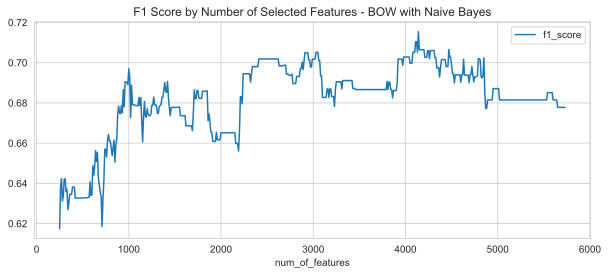

In [62]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [63]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

4090 4190 1


,num_of_features,f1_score,accuracy
389,4140,0.72,0.72
386,4110,0.71,0.71
387,4120,0.71,0.71
422,4470,0.71,0.71
391,4160,0.71,0.71


#### Get a more fine-grained look at the optimal number of features region

In [30]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bow, i, X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

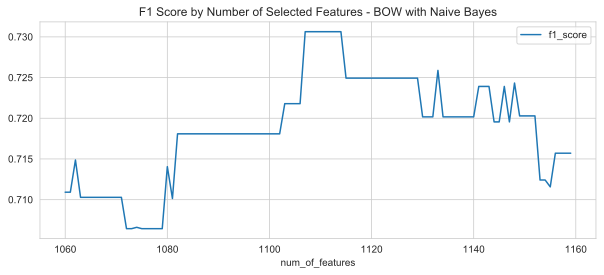

In [31]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with Naive Bayes", figsize=(10, 4))

In [32]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

1110


,num_of_features,f1_score,accuracy
50,1110,0.73,0.73
47,1107,0.73,0.73
54,1114,0.73,0.73
53,1113,0.73,0.73
52,1112,0.73,0.73


#### Benchmark BOW With Optimal Features Selected using Naive Bayes Model

In [33]:
model_nb_bow_opt = MultinomialNB()
cm_opt_bow, pred_opt_bow, f1_opt_bow, report_opt_bow, accuracy_opt_bow = SelectBestModelFeatures_Chi(model_nb_bow_opt, Opt_no_of_feat, X_train_bow, y_train, X_test_bow, y_test)

In [34]:
print(cm_opt_bow)

[[18  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 10  3  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  9 12  0  0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0 10  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1 18  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  2 18  3  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  3 20  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  6  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  9 17  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  2  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  8 14  7  0  0]
 [ 0  0  0  0  0  0  0  0  0  1  1  9  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 11  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  4 10]]


In [35]:
print("Label" + report_opt_bow)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.77      0.53      0.62        19
 coffee-ordering-2       0.52      0.75      0.62        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.86      0.90      0.88        20
   movie-tickets-2       0.78      0.82      0.80        22
   movie-tickets-3       0.87      0.83      0.85        24
  pizza-ordering-1       0.33      0.21      0.26        14
  pizza-ordering-2       0.65      0.74      0.69        23
restaurant-table-1       0.87      0.59      0.70        22
restaurant-table-2       0.47      0.82      0.60        17
restaurant-table-3       0.82      0.56      0.67        16
       uber-lyft-1       0.79      0.73      0.76        15
       uber-lyft-2       0.71      0.77      0.74        13

          accuracy                           0.73       250
         macro avg       0.75    

In [36]:
# Save benchmark output
rows_benchmarks.append(["BOW Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_opt_bow, accuracy_opt_bow])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73


## Bag of N-Grams Feature Extraction

In [64]:
from sklearn.feature_extraction.text import CountVectorizer

bv = CountVectorizer(ngram_range=(2,2))
bv_matrix = bv.fit_transform(X_train)
bv_matrix = bv_matrix.toarray()
bv_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [65]:
# get all unique words in the corpus
vocab = bv.get_feature_names()
# show document feature vectors
pd.DataFrame(bv_matrix, columns=vocab)

,able access,able accommodate,able arrange,able attend,able book,able check,able cook,able get,able handle,able help,able indoor,able make,able okay,able order,able pick,...,yup sounds,yup sure,yup thats,yupp anything,yupp ok,yusho noodles,zerozero san,ziggys location,zing like,zios near,zios pm,zios yes,zoo ok,zoo ride,zoo transport
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
747,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [66]:
# Get Bag of N-Gram features
X_train_bong = bv.fit_transform(X_train).toarray()
X_test_bong = bv.transform(X_test).toarray()
print (X_train_bong.shape) 
print (X_test_bong.shape) 
print (y_test.shape)

(750, 36204)
(250, 36204)
(250,)


## Bag of N-Grams Feature Benchmarking with Naive Bayes Classifier

In [40]:
from sklearn.naive_bayes import MultinomialNB

model_nb_bong = MultinomialNB()
cm_nb_bong, pred_nb_bong, f1_nb_bong, report_nb_bong, accuracy_nb_bong = Build_Model(model_nb_bong, X_train_bong, y_train, X_test_bong, y_test)

In [41]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes All Features", f1_nb_bong, accuracy_nb_bong])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59


In [42]:
from sklearn.metrics import confusion_matrix

cm_nb_bong

array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  8,  2,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0, 11, 11,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 17, 10,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  1,  3, 11,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  1, 16,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  2,  8,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0, 10, 15,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0, 17, 14,  8,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  8,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  9,  3],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6, 10]],
      dtype=int64)

In [43]:
from sklearn import metrics

print(report_nb_bong)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       0.73      0.42      0.53        19
 coffee-ordering-2       0.48      0.69      0.56        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.59      0.85      0.69        20
   movie-tickets-2       0.50      0.50      0.50        22
   movie-tickets-3       0.84      0.67      0.74        24
  pizza-ordering-1       0.18      0.14      0.16        14
  pizza-ordering-2       0.58      0.65      0.61        23
restaurant-table-1       0.75      0.14      0.23        22
restaurant-table-2       0.35      0.82      0.49        17
restaurant-table-3       0.67      0.50      0.57        16
       uber-lyft-1       0.69      0.60      0.64        15
       uber-lyft-2       0.59      0.77      0.67        13

          accuracy                           0.59       250
         macro avg       0.64      0.59      0.58       25

## Feature Selection: Bag of N-Gram Features with Naive Bayes Model Using Chi-Squared Selector

#### Iterate through number of features and get benchmark results

In [44]:
rows = []
for i in range(250, 5740, 10): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

#### Plot f1-score by number of selected features

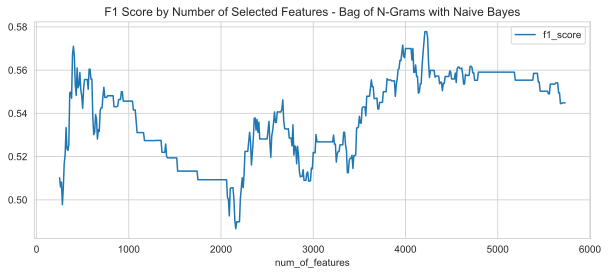

In [45]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [46]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

4180 4280 1


,num_of_features,f1_score,accuracy
398,4230,0.58,0.59
396,4210,0.58,0.59
397,4220,0.58,0.59
399,4240,0.58,0.58
395,4200,0.57,0.58


#### Get a more fine-grained look at the optimal number of features region

In [47]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_nb_bong, i, X_train_bong, y_train, X_test_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

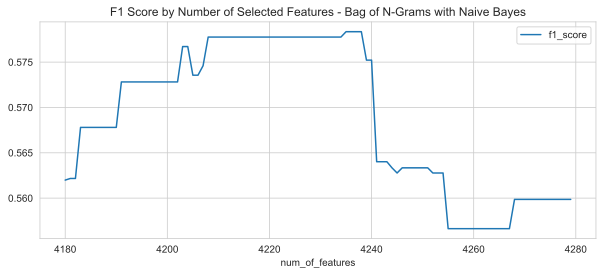

In [48]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Bag of N-Grams with Naive Bayes", figsize=(10, 4))

In [49]:
acc_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
58,4238,0.58,0.59
57,4237,0.58,0.59
56,4236,0.58,0.59
55,4235,0.58,0.59
50,4230,0.58,0.59


## Benchmark Bag of N-Grams With Optimal Features Selected using Naive Bayes Model

In [50]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat

4238

In [51]:
model_nb_bong_opt = MultinomialNB()
cm_optimal, pred_opt, f1_opt, report_opt, accuracy_opt = SelectBestModelFeatures_Chi(model_nb_bong_opt, Opt_no_of_feat, X_train_bong, y_train, X_test_bong, y_test)

In [52]:
print(report_opt)

precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       0.60      0.32      0.41        19
 coffee-ordering-2       0.43      0.62      0.51        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.65      0.85      0.74        20
   movie-tickets-2       0.57      0.55      0.56        22
   movie-tickets-3       0.73      0.67      0.70        24
  pizza-ordering-1       0.00      0.00      0.00        14
  pizza-ordering-2       0.52      0.65      0.58        23
restaurant-table-1       0.75      0.27      0.40        22
restaurant-table-2       0.42      0.82      0.56        17
restaurant-table-3       0.67      0.62      0.65        16
       uber-lyft-1       0.73      0.53      0.62        15
       uber-lyft-2       0.53      0.77      0.62        13

          accuracy                           0.59       250
         macro avg       0.61      0.59      0.58       25

In [53]:
# Save benchmark output
rows_benchmarks.append(["Bag of N-Gram Naive Bayes Optimal Features Selected: 960", f1_opt, accuracy_opt])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59


## TF-IDF Feature Extraction

In [54]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)
#vocab_tfidf = count_vect.vocabulary_
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

(750, 4913)
(250, 4913)


## TF-IDF Baseline Benchmarking with Naive Bayes Classifier: Multinomial variant

In [55]:
clf = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_tfidf, pred_nb_tfidf, f1_nb_tfidf, report_nb_tfidf, accuracy_nb_tfidf = Build_Model(clf, X_train_tfidf, y_train, X_test_tfidf, y_test)

#### Make Some Predictions

In [56]:
X_new_data_counts = count_vect.transform(["appointment online car checking bmw okay hold minute problem okay entered thank need bring need alignment"])
X_new_data_tfidf = tfidf_transformer.fit_transform(X_new_data_counts)
print(X_new_data_tfidf.shape)
y_pred_new = clf.predict(X_new_data_tfidf)
y_pred_new

(1, 4913)


array(['auto-repair-appt-1'], dtype='<U18')

#### Metrics for TF-IDF with Naive Bayes Classifier: Multinomial variant

In [57]:
from sklearn.metrics import confusion_matrix

cm_nb_tfidf

array([[18,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 19, 15,  1,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1, 20,  6,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0, 15,  8,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  7,  0,  1, 14,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  4,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 11, 19,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  1,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0, 20, 16, 13,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  9,  6],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  7]],
      dtype=int64)

In [58]:
from sklearn import metrics

print("Label" + report_nb_tfidf)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.00      0.00      0.00        19
 coffee-ordering-2       0.41      0.94      0.57        16
      movie-finder       0.00      0.00      0.00        11
   movie-tickets-1       0.69      1.00      0.82        20
   movie-tickets-2       0.60      0.68      0.64        22
   movie-tickets-3       0.64      0.58      0.61        24
  pizza-ordering-1       0.20      0.07      0.11        14
  pizza-ordering-2       0.63      0.83      0.72        23
restaurant-table-1       0.67      0.09      0.16        22
restaurant-table-2       0.32      0.94      0.48        17
restaurant-table-3       1.00      0.19      0.32        16
       uber-lyft-1       0.60      0.60      0.60        15
       uber-lyft-2       0.54      0.54      0.54        13

          accuracy                           0.56       250
         macro avg       0.52    

In [59]:
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes All Features", f1_nb_tfidf, accuracy_nb_tfidf])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56


In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler

def SelectBestModelFeatures_Chi_sparse(model, num_feats, features_train, labels_train, features_test, labels_test):
    X_norm = MaxAbsScaler().fit_transform(features_train, labels_train)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, labels_train)
    chi_support = chi_selector.get_support()
    
    X_train_chi = features_train[:,chi_support]
    X_test_chi = features_test[:,chi_support]
    classifier_chi = model.fit(X_train_chi, labels_train)

    # Predicter to output
    predict_chi = classifier_chi.predict(X_test_chi)

    # Metrics to output
    cm_chi = confusion_matrix(predict_chi,labels_test)
    report_chi = metrics.classification_report(labels_test, predict_chi)
    f1_chi = metrics.f1_score(labels_test, predict_chi, average='weighted')
    accuracy_chi = cm_chi.trace()/cm_chi.sum()

    return cm_chi, predict_chi, f1_chi, report_chi, accuracy_chi

## Feature Selection - TF-IDF with Naive Bayes

In [61]:
rows = []
for i in range(50, 4850, 100): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

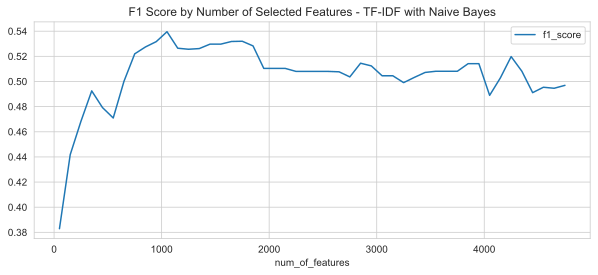

In [62]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [63]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

1000 1100 1


,num_of_features,f1_score,accuracy
10,1050,0.54,0.59
17,1750,0.53,0.58
16,1650,0.53,0.58
9,950,0.53,0.58
15,1550,0.53,0.58


#### Take closer look at region around optimal features

In [64]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi_sparse(clf, i, X_train_tfidf, y_train, X_test_tfidf, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_tfidf_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

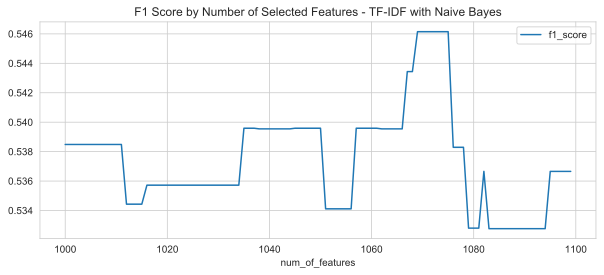

In [65]:
sel_nb_tfidf_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - TF-IDF with Naive Bayes", figsize=(10, 4))

In [66]:
Opt_no_of_feat = int(sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_tfidf_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
75,1075,0.55,0.60
74,1074,0.55,0.60
73,1073,0.55,0.60
72,1072,0.55,0.60
71,1071,0.55,0.60


## Benchmark TF-IDF Features with Naive Bayes on Optimal Features

In [67]:
cm_tf_nb, pred_tf_nb, f1_tf_nb, report_tf_nb, accuracy_tf_nb = SelectBestModelFeatures_Chi_sparse(clf, Opt_no_of_feat, X_train_tfidf, y_train, X_test_tfidf, y_test)
# Save benchmark output
rows_benchmarks.append(["TF-IDF Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_tf_nb, accuracy_tf_nb])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60


#### Metrics For Each Class

In [68]:
from sklearn import metrics
print("Label" + report_tf_nb)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       1.00      0.05      0.10        19
 coffee-ordering-2       0.43      0.94      0.59        16
      movie-finder       1.00      0.18      0.31        11
   movie-tickets-1       0.67      1.00      0.80        20
   movie-tickets-2       0.65      0.68      0.67        22
   movie-tickets-3       0.64      0.58      0.61        24
  pizza-ordering-1       0.33      0.14      0.20        14
  pizza-ordering-2       0.66      0.83      0.73        23
restaurant-table-1       0.67      0.09      0.16        22
restaurant-table-2       0.33      0.94      0.49        17
restaurant-table-3       0.80      0.25      0.38        16
       uber-lyft-1       0.83      0.67      0.74        15
       uber-lyft-2       0.69      0.85      0.76        13

          accuracy                           0.60       250
         macro avg       0.69    

## Word2Vec Feature Extraction

In [69]:
from gensim.models import word2vec

# tokenize sentences in corpus
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 30          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                          window=window_context, min_count=min_word_count,
                          sample=sample, iter=50)

# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['pizza', 'terminator', 'star', 'east', 'korean','playing']}
similar_words

{'pizza': ['sausage', 'large', 'topping', 'bacon', 'jack'],
 'terminator': ['abyss', 'judgment', 'avatar', 'sigourney', 'weaver'],
 'star': ['wars', 'jedi', 'runner', 'blade', 'iv'],
 'east': ['enjoyed', 'lower', 'uptown', 'stadium', 'siri'],
 'korean': ['lauderhill', 'bbgo', 'pig', 'germantown', 'pinellas'],
 'playing': ['pet', 'times', 'ocala', 'hell', 'uptown']}

#### Visualizing word embeddings

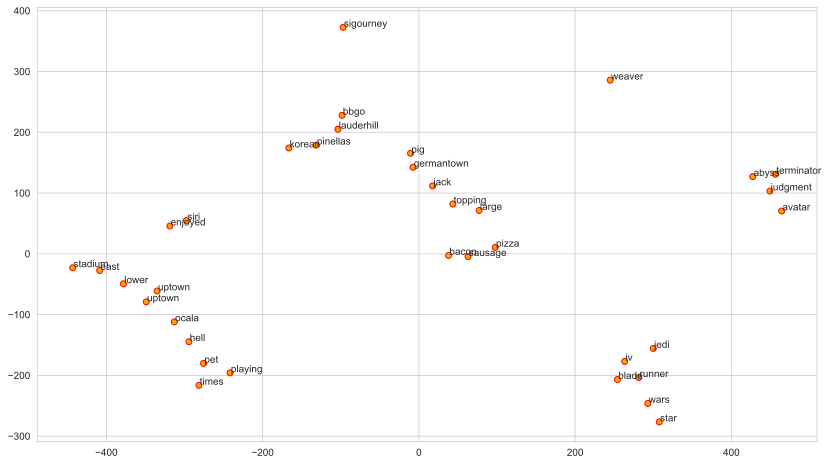

In [70]:
from sklearn.manifold import TSNE

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

#### Applying the word2vec model on our Train dataset

In [71]:
wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]
tokenized_corpus_test = [wpt.tokenize(document) for document in X_test]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)

In [72]:
def Get_W2V_Model(feat_size):
    w2v_mod = word2vec.Word2Vec(tokenized_corpus, size=feat_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
    return w2v_mod

#### Do a Word Test

In [73]:
w2v_model.wv['jedi']

array([-0.32215646, -0.25536215,  0.28881735,  0.37460986, -0.1785209 ,
        0.15640481, -0.24927685,  0.45267016, -0.11916102,  0.09655154,
       -0.01096867, -0.04109757, -0.14419763, -0.27617273,  0.3699495 ,
        0.70794743, -0.89402825,  0.7922779 , -0.05307756,  0.591101  ,
        0.26935577, -0.51421994, -0.18169962,  0.49699754,  0.18158895,
        0.8309414 , -0.1788033 ,  0.30659837, -0.0174735 , -0.10513857,
       -0.0435609 ,  0.3113637 , -0.22355027, -0.41728494, -0.08063657,
       -0.44692856,  0.27115574,  0.10438384, -0.54383045, -0.6677722 ,
        0.20307443, -0.7444285 , -0.6824159 , -0.14899632,  0.2717918 ,
        0.30334166, -0.643413  , -0.10315035, -0.25229535, -0.16166411,
        0.71972525,  0.21391109, -0.17943202, -0.12783799, -0.23111914,
       -0.56914175, -0.8249163 , -0.3141917 ,  0.2863672 , -0.16364092,
        0.18841425,  0.51483166,  0.12446295, -0.5553186 ,  0.43252727,
       -0.29227576, -0.33111745,  0.07952029, -0.28381705,  0.03

#### Build framework for getting document level embeddings

In [74]:
def average_word_vectors(words, model, vocabulary, num_features):
    
    feature_vector = np.zeros((num_features,),dtype="float64")
    nwords = 0.
    
    for word in words:
        if word in vocabulary: 
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model[word])
    
    if nwords:
        feature_vector = np.divide(feature_vector, nwords)
        
    return feature_vector
    
   
def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [75]:
w2v_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=w2v_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.45,-0.83,-0.52,-0.02,0.66,0.08,-0.98,-0.58,-0.65,-0.02,1.09,-0.45,0.43,-0.19,-0.46,...,0.95,0.28,0.35,-0.76,0.22,0.25,0.25,0.15,-0.70,0.42,0.07,-0.40,0.76,0.38,-0.06
1,0.26,-0.27,0.53,0.92,-0.06,0.03,1.00,0.49,0.33,0.28,0.30,-0.32,-0.12,0.32,-0.58,...,-0.15,-0.20,-0.48,0.15,-0.75,1.07,0.39,-0.96,0.60,0.17,0.21,0.39,0.50,0.23,-0.41
2,-0.47,0.21,-0.33,-0.58,0.64,-0.60,-0.51,-0.01,0.50,-0.06,0.82,0.03,0.21,0.92,0.82,...,-0.66,-0.71,0.53,-0.20,0.54,0.19,-0.64,-0.52,0.92,-0.31,-0.43,0.24,-0.75,0.57,-0.02
3,-1.32,-1.03,-0.96,0.61,0.02,1.15,-0.24,-0.50,-0.31,0.74,0.16,0.96,-0.06,0.08,-0.95,...,-0.60,-0.75,1.01,0.01,0.67,-0.51,0.06,-0.70,0.32,-0.29,1.18,0.93,-0.66,-0.07,0.30
4,-0.59,-1.01,-0.25,0.05,0.64,0.18,-0.60,-0.45,-0.37,-0.09,1.12,-0.31,0.49,0.13,-0.58,...,-0.12,-0.81,0.33,-0.57,0.80,0.14,0.31,-0.42,0.46,0.12,0.62,-0.04,-0.05,0.65,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.21,0.16,0.20,-0.10,-0.02,0.12,-0.47,0.26,0.22,-0.41,0.72,-0.31,0.03,0.67,0.31,...,-0.02,-0.39,0.25,-0.18,0.17,0.45,0.14,-0.83,0.71,0.27,-0.09,-0.09,-0.06,0.52,0.26
746,-0.55,-0.40,0.77,0.53,0.33,0.44,1.22,-0.95,-0.69,-0.19,0.22,-0.19,0.66,0.13,-1.89,...,0.03,0.33,1.12,0.79,1.10,-0.72,0.02,0.63,-0.79,0.25,0.42,-0.09,-0.01,0.52,0.53
747,-0.34,-0.53,0.30,-0.35,0.20,-0.03,-0.04,-0.42,0.25,-0.19,0.93,-0.47,0.38,0.37,0.67,...,0.06,-0.18,0.13,-0.27,0.43,0.30,-0.24,-0.45,0.83,0.18,0.15,-0.09,0.04,0.38,-0.21
748,-0.43,-0.73,-0.66,0.21,0.21,0.21,0.05,-0.66,-0.21,0.53,0.70,-0.33,0.76,0.41,-0.96,...,-0.62,-0.61,-0.29,-0.19,-0.03,0.31,0.45,-0.57,0.36,0.03,0.70,0.33,0.12,0.66,-0.69


In [76]:
w2v_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=w2v_model,
                                             num_features=feature_size)
                                             
print(w2v_test_array.shape)

(250, 100)


## Word2vec Feature Benchmarking with Naive Bayes Classifier

In [77]:
from sklearn.naive_bayes import GaussianNB

#model_w2v_nb = MultinomialNB()
model_w2v_nb = GaussianNB()
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, 100, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes All Features", f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60


In [78]:
cm_nb_w2v

array([[16,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  7,  7,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 11,  8,  0,  0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 14,  6,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  6, 13,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  3, 18,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  1,  0,  0,  0,  0,  0,  5,  9,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  7, 14,  0,  0,  0,  0,  0],
       [ 1,  0,  1,  0,  0,  0,  0,  0,  0, 13,  1,  3,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  4,  7,  2,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  9, 11,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  4],
       [ 1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  8,  9]],
      dtype=int64)

In [79]:
print("Label" + report_nb_w2v)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      0.89      0.94        18
 coffee-ordering-1       0.50      0.37      0.42        19
 coffee-ordering-2       0.38      0.50      0.43        16
      movie-finder       1.00      0.91      0.95        11
   movie-tickets-1       0.67      0.70      0.68        20
   movie-tickets-2       0.52      0.59      0.55        22
   movie-tickets-3       0.86      0.75      0.80        24
  pizza-ordering-1       0.33      0.36      0.34        14
  pizza-ordering-2       0.67      0.61      0.64        23
restaurant-table-1       0.65      0.59      0.62        22
restaurant-table-2       0.54      0.41      0.47        17
restaurant-table-3       0.44      0.69      0.54        16
       uber-lyft-1       0.60      0.40      0.48        15
       uber-lyft-2       0.50      0.69      0.58        13

          accuracy                           0.60       250
         macro avg       0.62    

## Feature Selection - Word2Vec Features with Naive Bayes Model

In [80]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_w2v_nb, i, w2v_feature_array, y_train, w2v_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_w2v_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

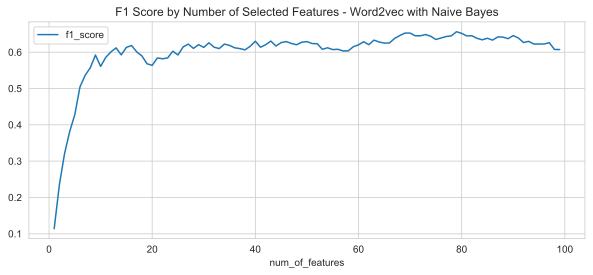

In [81]:
sel_nb_w2v_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec with Naive Bayes", figsize=(10, 4))

In [82]:
Opt_no_of_feat = int(sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_w2v_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
78,79,0.66,0.66
69,70,0.65,0.65
68,69,0.65,0.65
79,80,0.65,0.65
72,73,0.65,0.65


In [83]:
cm_nb_w2v, pred_nb_w2v, f1_nb_w2v, report_nb_w2v, accuracy_nb_w2v  = SelectBestModelFeatures_Chi(model_w2v_nb, Opt_no_of_feat, w2v_feature_array, y_train, w2v_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_w2v, accuracy_nb_w2v])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66


## Word2vec features Extraction with Fastext Model

In [84]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in X_train]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, size=feature_size, window=window_context, 
                    min_count=min_word_count,sample=sample, sg=1, iter=50)

In [85]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['rental', 'pizza', 'terminator', 'star', 'audi', 'east', 'korean','playing']}
similar_words

{'rental': ['let', 'looking', 'well', 'sure', 'time'],
 'pizza': ['pepperoni', 'cheese', 'pizzas', 'toppings', 'large'],
 'terminator': ['terminal', 'jfk', 'airport', 'traffic', 'linda'],
 'star': ['recommendations', 'wars', 'something', 'episode', 'recommended'],
 'audi': ['popcorn', 'watched', 'austin', 'texas', 'visa'],
 'east': ['broccoli', 'pies', 'late', 'nine', 'well'],
 'korean': ['bbq', 'reservations', 'p', 'grill', 'alex'],
 'playing': ['movie', 'see', 'theater', 'tickets', 'showing']}

#### PCA on Fasttext Model

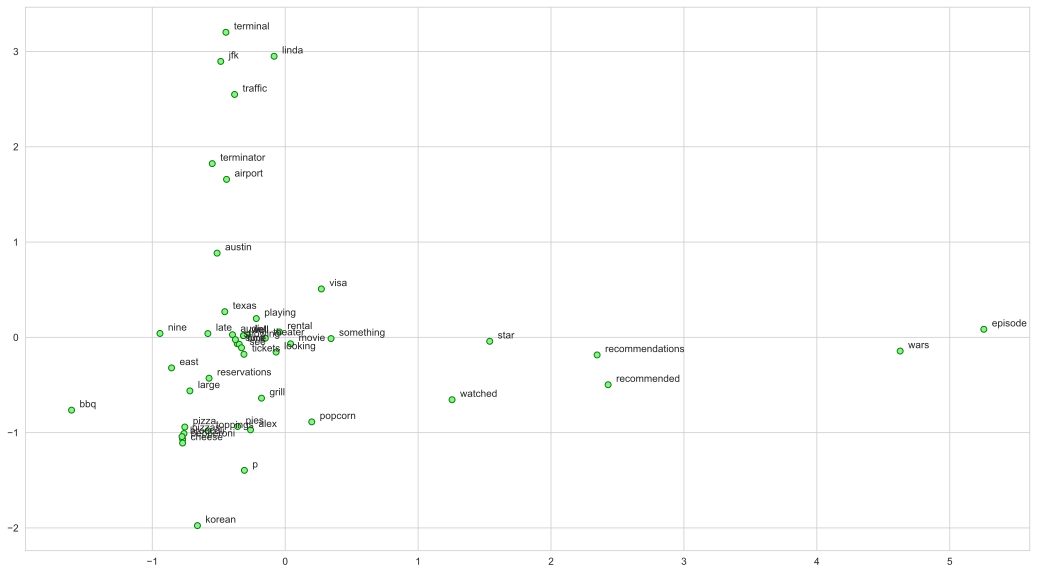

In [86]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [87]:
print(P.shape)

(48, 2)


In [88]:
ft_model.wv['rental']

array([ 0.14320092, -0.08772472, -0.21409072, -0.3321557 ,  0.16198756,
       -0.09128235,  0.45122248,  0.17695946, -0.28787157,  0.06355111,
        0.07830023, -0.1941516 ,  0.17160933, -0.20840687,  0.31993073,
       -0.06575908, -0.30635872,  0.04672587,  0.14248927, -0.18184376,
        0.06738096, -0.31776607,  0.40318805, -0.13934949, -0.10835174,
       -0.12004109, -0.21035695,  0.24591494, -0.01685474, -0.29699358,
       -0.19467358,  0.0593622 ,  0.15167359, -0.14583743,  0.17052136,
       -0.08372065, -0.06083521, -0.06975104, -0.5557205 , -0.1186133 ,
        0.05043286,  0.051803  ,  0.10414893,  0.28178173, -0.09327526,
        0.11997101, -0.0699309 ,  0.24233079,  0.01482999,  0.0285987 ,
       -0.17278029, -0.2754742 , -0.34433228,  0.3585826 ,  0.28904635,
        0.05464154, -0.2892611 , -0.02134229,  0.13393575, -0.01384271,
       -0.14892377,  0.01929763,  0.02553422, -0.18757913, -0.21825944,
       -0.19049186,  0.18194774, -0.3671299 ,  0.14955613,  0.04

In [89]:
print(ft_model.wv.similarity(w1='pizza', w2='born'))
print(ft_model.wv.similarity(w1='playing', w2='movie'))

0.22585046
0.7491547


In [90]:
st1 = "'tickets movie showing john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "pepperoni pizzas cheese pies"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ 'tickets movie showing john ]: 'tickets
Odd one out for [ pepperoni pizzas cheese pies ]: pies


## WOrd2Vec Features from Fastext Benchmarking with Naive Bayes Model

In [91]:
w2v_ft_feature_array = averaged_word_vectorizer(corpus=tokenized_corpus, model=ft_model,
                                             num_features=feature_size)
pd.DataFrame(w2v_feature_array)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.45,-0.83,-0.52,-0.02,0.66,0.08,-0.98,-0.58,-0.65,-0.02,1.09,-0.45,0.43,-0.19,-0.46,...,0.95,0.28,0.35,-0.76,0.22,0.25,0.25,0.15,-0.70,0.42,0.07,-0.40,0.76,0.38,-0.06
1,0.26,-0.27,0.53,0.92,-0.06,0.03,1.00,0.49,0.33,0.28,0.30,-0.32,-0.12,0.32,-0.58,...,-0.15,-0.20,-0.48,0.15,-0.75,1.07,0.39,-0.96,0.60,0.17,0.21,0.39,0.50,0.23,-0.41
2,-0.47,0.21,-0.33,-0.58,0.64,-0.60,-0.51,-0.01,0.50,-0.06,0.82,0.03,0.21,0.92,0.82,...,-0.66,-0.71,0.53,-0.20,0.54,0.19,-0.64,-0.52,0.92,-0.31,-0.43,0.24,-0.75,0.57,-0.02
3,-1.32,-1.03,-0.96,0.61,0.02,1.15,-0.24,-0.50,-0.31,0.74,0.16,0.96,-0.06,0.08,-0.95,...,-0.60,-0.75,1.01,0.01,0.67,-0.51,0.06,-0.70,0.32,-0.29,1.18,0.93,-0.66,-0.07,0.30
4,-0.59,-1.01,-0.25,0.05,0.64,0.18,-0.60,-0.45,-0.37,-0.09,1.12,-0.31,0.49,0.13,-0.58,...,-0.12,-0.81,0.33,-0.57,0.80,0.14,0.31,-0.42,0.46,0.12,0.62,-0.04,-0.05,0.65,-0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,-0.21,0.16,0.20,-0.10,-0.02,0.12,-0.47,0.26,0.22,-0.41,0.72,-0.31,0.03,0.67,0.31,...,-0.02,-0.39,0.25,-0.18,0.17,0.45,0.14,-0.83,0.71,0.27,-0.09,-0.09,-0.06,0.52,0.26
746,-0.55,-0.40,0.77,0.53,0.33,0.44,1.22,-0.95,-0.69,-0.19,0.22,-0.19,0.66,0.13,-1.89,...,0.03,0.33,1.12,0.79,1.10,-0.72,0.02,0.63,-0.79,0.25,0.42,-0.09,-0.01,0.52,0.53
747,-0.34,-0.53,0.30,-0.35,0.20,-0.03,-0.04,-0.42,0.25,-0.19,0.93,-0.47,0.38,0.37,0.67,...,0.06,-0.18,0.13,-0.27,0.43,0.30,-0.24,-0.45,0.83,0.18,0.15,-0.09,0.04,0.38,-0.21
748,-0.43,-0.73,-0.66,0.21,0.21,0.21,0.05,-0.66,-0.21,0.53,0.70,-0.33,0.76,0.41,-0.96,...,-0.62,-0.61,-0.29,-0.19,-0.03,0.31,0.45,-0.57,0.36,0.03,0.70,0.33,0.12,0.66,-0.69


In [92]:
w2v_ft_test_array = averaged_word_vectorizer(corpus=tokenized_corpus_test, model=ft_model,
                                             num_features=feature_size)

In [93]:
model_ft_nb = GaussianNB()
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, 100, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec Fastext Naive Bayes All Features", f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60


## Word2Vec from Fastext Model Feature Selction with Naive Bayes Model

In [94]:
rows = []
for i in range(1, 100, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_ft_nb, i, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_ft_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

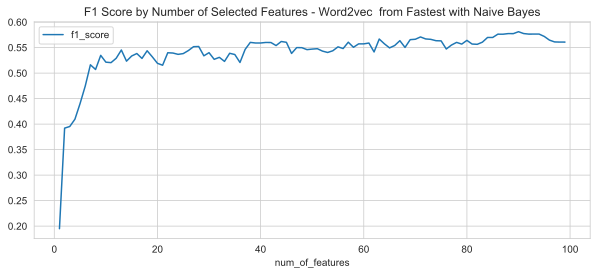

In [95]:
sel_nb_ft_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - Word2vec  from Fastest with Naive Bayes", figsize=(10, 4))

In [96]:
Opt_no_of_feat = int(sel_nb_ft_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_ft_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
89,90,0.58,0.61
90,91,0.58,0.61
87,88,0.58,0.61
88,89,0.58,0.61
92,93,0.58,0.61


## Benchmarking Word2Vec Fastext with Naive Bayes on Optimal number of Features

In [97]:
cm_nb_ft, pred_nb_ft, f1_nb_ft, report_nb_ft, accuracy_nb_ft  = SelectBestModelFeatures_Chi(model_ft_nb, Opt_no_of_feat, w2v_ft_feature_array, y_train, w2v_ft_test_array, y_test)
# Save benchmark output
rows_benchmarks.append(["Word2Vec from Fastest Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_ft, accuracy_nb_ft])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.63,0.64
1,BOW Naive Bayes Optimal Features Selected: 1110,0.73,0.73
2,Bag of N-Gram Naive Bayes All Features,0.58,0.59
3,Bag of N-Gram Naive Bayes Optimal Features Selected: 960,0.58,0.59
4,TF-IDF Naive Bayes All Features,0.49,0.56
5,TF-IDF Naive Bayes Optimal Features Selected: 1075,0.55,0.60
6,Word2Vec Naive Bayes All Features,0.61,0.60
7,Word2Vec Naive Bayes Optimal Features Selected: 79,0.66,0.66
8,Word2Vec Fastext Naive Bayes All Features,0.56,0.60
9,Word2Vec from Fastest Naive Bayes Optimal Features Selected: 90,0.58,0.61


## Feature Extraction: Glove Word Embeddings

#### GloVe Embeddings with spaCy

In [98]:
import spacy

nlp = spacy.load('en_vectors_web_lg')

total_vectors = len(nlp.vocab.vectors)
print('Total word vectors:', total_vectors)

Total word vectors: 1070971


#### Visualize GloVe word embeddings

In [99]:
unique_words = list(set([word for sublist in [doc.split() for doc in X_train] for word in sublist]))
word_glove_vectors = np.array([nlp(word).vector for word in unique_words])

pd.DataFrame(word_glove_vectors, index=unique_words)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
score,-0.42,0.69,-0.06,0.01,-0.07,-0.49,-0.18,-0.02,0.81,1.82,0.16,0.56,-0.21,0.28,0.09,...,0.13,0.07,-0.71,0.37,0.22,-0.09,0.03,0.25,0.61,0.68,0.07,-0.07,-0.03,0.39,-0.17
specialty,0.11,-0.14,0.32,-0.35,0.84,-0.17,-0.20,0.05,-0.38,1.67,-0.37,0.05,0.11,-0.56,0.22,...,0.30,-0.04,0.39,-0.49,0.32,0.07,-0.24,-0.57,-0.08,-0.81,-0.72,0.09,-0.47,0.64,0.24
indie,0.56,-0.07,-0.22,0.43,0.65,-0.14,-0.06,-0.91,0.03,1.14,-0.20,0.00,-0.12,-0.02,0.28,...,0.19,-0.00,-0.99,-0.14,-0.19,-1.00,0.17,0.24,0.68,-0.12,-0.17,0.61,0.01,-0.39,0.19
interests,0.03,-0.34,-0.03,-0.06,-0.21,-0.04,-0.49,0.13,-0.15,3.18,-0.79,0.11,0.04,0.04,0.05,...,0.36,0.20,0.41,-0.06,0.08,-0.46,-0.08,-0.26,-0.40,0.61,0.09,0.11,-0.61,-0.01,0.21
frapac,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
luggage,0.11,0.18,0.04,-0.05,0.58,0.65,-0.39,-0.69,-0.27,1.11,0.02,-0.30,0.13,0.42,-0.33,...,-0.14,0.12,0.23,0.26,0.22,-0.46,-0.36,0.84,-0.52,0.65,-0.16,0.64,0.49,0.05,-0.16
ohlets,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
seth,-0.57,0.53,0.33,0.44,-0.36,0.03,0.38,-0.83,0.18,-0.18,-0.26,-0.88,-0.15,0.00,0.00,...,-0.14,0.54,0.30,0.35,0.03,0.42,-0.22,-0.46,0.32,0.18,-0.38,-0.29,0.31,-0.50,0.14
hilside,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [100]:
unique_words_test = list(set([word for sublist in [doc.split() for doc in X_test] for word in sublist]))
word_glove_vectors_test = np.array([nlp(word).vector for word in unique_words])
print(word_glove_vectors_test.shape)

(4931, 300)


#### GloVe Embeddings with Flair

In [27]:
from flair.embeddings import WordEmbeddings, DocumentRNNEmbeddings

glove_embedding = WordEmbeddings('glove')
document_embeddings = DocumentRNNEmbeddings([glove_embedding])

In [28]:
from flair.embeddings import Sentence

# create an example sentence
sentence = Sentence('The grass is green . And the sky is blue .')
# embed the sentence with our document embedding
document_embeddings.embed(sentence)
# now check out the embedded sentence.
print(sentence.get_embedding())

tensor([ 0.2966, -0.5177,  0.1471, -0.1276, -0.2396,  0.0459, -0.5188, -0.2184,
        -0.2018,  0.0972, -0.0480, -0.1231, -0.5369,  0.2706,  0.2454,  0.1279,
         0.4856,  0.0813, -0.2331,  0.6016,  0.2361, -0.0327, -0.1706,  0.0941,
        -0.2872, -0.0598,  0.0631, -0.2008, -0.4574, -0.1284,  0.0152, -0.0508,
         0.3159,  0.0849, -0.0482,  0.1683, -0.2399, -0.1331, -0.2446,  0.2090,
        -0.3322,  0.1576,  0.0220,  0.3653,  0.1181,  0.3120, -0.2711,  0.2109,
        -0.0931,  0.0993, -0.4092,  0.1571, -0.1876,  0.0526, -0.5570,  0.0207,
         0.2441, -0.2208, -0.1412,  0.1685, -0.2295,  0.2849, -0.0265,  0.0803,
        -0.4606, -0.3083,  0.0942, -0.1204, -0.1735, -0.3485, -0.1673,  0.0622,
        -0.5380,  0.3504, -0.0256, -0.1330, -0.0813, -0.1941,  0.0565, -0.0520,
        -0.0285, -0.2979, -0.0353,  0.2243, -0.1355, -0.1170,  0.0981,  0.2599,
         0.0155, -0.0702, -0.1307, -0.0766, -0.4048, -0.1087,  0.0144,  0.3288,
         0.4779,  0.0128, -0.2894,  0.00

In [34]:
from nltk.tokenize import word_tokenize

def Get_Glove_Features(corpus):
    dataset_size = len(corpus)
    X = np.zeros((dataset_size, 128))
    for iter in range(0, dataset_size):
        text = corpus[iter]
        sentence = Sentence(text)
        document_embeddings.embed(sentence)
        X[iter] = sentence.get_embedding().detach().numpy()
    return X

In [35]:
x_train_glove = Get_Glove_Features(X_train)
x_test_glove = Get_Glove_Features(X_test)
print(x_train_glove.shape, x_test_glove.shape)

(750, 128) (250, 128)


In [48]:
pd.DataFrame(x_test_glove)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127
0,-0.24,-0.09,0.13,0.01,-0.47,0.31,-0.19,-0.18,-0.28,0.19,0.20,0.42,0.01,-0.13,0.06,...,-0.05,0.02,-0.15,-0.25,-0.25,-0.23,-0.18,0.17,-0.24,0.02,-0.07,0.14,-0.12,0.22,-0.01
1,0.01,-0.16,0.15,-0.07,-0.30,0.22,-0.37,-0.08,-0.51,0.08,0.09,0.38,0.06,0.00,0.07,...,-0.07,-0.32,-0.32,-0.10,0.09,-0.10,-0.19,0.38,0.22,-0.37,0.19,-0.04,-0.02,-0.04,-0.20
2,-0.06,-0.07,0.08,-0.01,-0.29,0.23,-0.22,-0.01,-0.45,0.06,0.01,0.38,0.15,0.02,-0.01,...,-0.08,-0.30,-0.17,-0.17,0.05,-0.16,-0.06,0.27,0.17,-0.34,0.22,0.01,-0.10,-0.02,-0.15
3,-0.05,-0.26,0.00,-0.07,-0.18,0.03,-0.35,-0.36,-0.23,0.10,0.06,0.06,-0.23,0.05,0.39,...,0.32,-0.32,-0.44,-0.06,-0.11,0.13,-0.14,0.26,0.15,-0.23,-0.01,-0.31,0.27,-0.29,0.11
4,-0.34,0.00,0.22,0.25,-0.48,0.47,-0.04,-0.21,-0.24,0.16,0.14,0.41,0.12,-0.28,0.00,...,-0.07,0.07,-0.12,-0.45,-0.34,-0.29,-0.10,0.05,-0.26,-0.14,-0.00,0.21,-0.20,0.31,-0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.16,-0.26,0.01,-0.12,-0.18,0.02,-0.46,-0.22,-0.39,0.15,0.03,0.22,-0.31,0.07,0.17,...,0.11,-0.29,-0.43,0.12,-0.16,0.14,-0.17,0.25,-0.02,-0.17,0.03,-0.23,0.27,-0.11,-0.06
246,-0.04,-0.30,0.18,-0.06,-0.45,0.22,-0.28,-0.26,-0.54,0.04,-0.00,0.00,-0.25,0.15,0.09,...,0.30,-0.32,-0.42,0.18,-0.17,0.14,0.00,0.31,0.15,-0.22,0.11,-0.42,0.25,-0.18,0.11
247,0.12,-0.13,0.10,-0.05,-0.19,0.17,-0.16,-0.13,-0.39,-0.05,-0.14,0.06,-0.07,0.04,0.10,...,0.14,-0.13,-0.35,-0.04,-0.22,0.01,-0.03,0.20,0.12,-0.15,-0.02,-0.20,0.22,-0.11,-0.14
248,-0.05,-0.11,0.04,-0.03,-0.29,0.14,-0.17,-0.06,-0.43,0.02,-0.04,0.26,0.10,0.03,0.01,...,-0.02,-0.31,-0.16,-0.13,-0.04,-0.10,-0.01,0.25,0.19,-0.25,0.12,-0.07,0.00,-0.04,-0.14


In [49]:
from sklearn.naive_bayes import GaussianNB

model_glove_nb = GaussianNB()
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove = Build_Model(model_glove_nb, x_train_glove, y_train, x_test_glove, y_test)
# Save benchmark output
# rows_benchmarks.append(["Glove with Naive Bayes All Features", f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

In [50]:
print(report_nb_glove)

precision    recall  f1-score   support

auto-repair-appt-1       0.12      0.06      0.08        18
 coffee-ordering-1       0.00      0.00      0.00        19
 coffee-ordering-2       0.17      0.12      0.14        16
      movie-finder       0.21      0.27      0.24        11
   movie-tickets-1       0.12      0.15      0.13        20
   movie-tickets-2       0.26      0.27      0.27        22
   movie-tickets-3       0.08      0.17      0.11        24
  pizza-ordering-1       0.40      0.29      0.33        14
  pizza-ordering-2       0.22      0.26      0.24        23
restaurant-table-1       0.31      0.18      0.23        22
restaurant-table-2       0.30      0.41      0.35        17
restaurant-table-3       0.00      0.00      0.00        16
       uber-lyft-1       0.20      0.13      0.16        15
       uber-lyft-2       0.06      0.08      0.07        13

          accuracy                           0.17       250
         macro avg       0.18      0.17      0.17       25

## Feature Selection on Glove Features with Naive Bayes Model

In [107]:
rows = []
for i in range(1, 128, 1): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_glove_nb, i, x_train_glove, y_train, x_test_glove, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb_glove_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

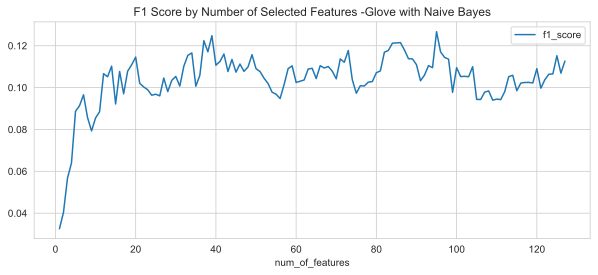

In [108]:
sel_nb_glove_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -Glove with Naive Bayes", figsize=(10, 4))

In [109]:
Opt_no_of_feat = int(sel_nb_glove_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
sel_nb_glove_df.sort_values(by='f1_score', ascending=False).head(5)

,num_of_features,f1_score,accuracy
94,95,0.13,0.12
38,39,0.12,0.13
36,37,0.12,0.13
85,86,0.12,0.12
84,85,0.12,0.12


In [110]:
cm_nb_glove, pred_nb_glove, f1_nb_glove, report_nb_glove, accuracy_nb_glove  = SelectBestModelFeatures_Chi(model_glove_nb, Opt_no_of_feat, x_train_glove, y_train, x_test_glove, y_test)

# Save benchmark output
# rows_benchmarks.append(["Glove Naive Bayes Optimal Features Selected: " + str(Opt_no_of_feat), f1_nb_glove, accuracy_nb_glove])
# df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
# df_benchmarks

In [111]:
# cm_nb_glove

In [112]:
# print("Label" + report_nb_glove)

#### Leave the Glove Feature result out for now since it clearly is problematic

## Combining Features

## Combine BOW and BAG of nGrams

In [71]:
def Get_Combined_Features(feat_1, feat_2):
    row_size = len(feat_1)
    col_size_1 = np.size(feat_1, axis=1)
    col_size_total = np.size(feat_1, axis=1) + np.size(feat_2, axis=1)
    X = np.zeros((row_size, col_size_total))
    #rint(X.shape, col_size_1, np.size(feat_2, axis=1), col_size)
    for i in range(0, row_size):
        for j in range(0, col_size_1):
            X[i, j] = feat_1[i, j]

        for k in range(col_size_1, col_size_total):
            X[i, k] = feat_2[i, k - col_size_1]
    return X

In [72]:
from numpy import column_stack

x_train_bow_bong = Get_Combined_Features(X_train_bow, X_train_bong)
x_test_bow_bong = Get_Combined_Features(X_test_bow, X_test_bong)

In [73]:
print(x_train_bow_bong.shape)
print(x_test_bow_bong.shape)

(750, 41975)
(250, 41975)


In [74]:
pd.DataFrame(x_test_bow_bong)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,...,41960,41961,41962,41963,41964,41965,41966,41967,41968,41969,41970,41971,41972,41973,41974
0,0.00,12.00,12.00,0.00,1.00,1.00,2.00,0.00,0.00,2.00,1.00,0.00,1.00,1.00,3.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,1.00,3.00,0.00,0.00,3.00,0.00,4.00,0.00,0.00,0.00,1.00,4.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,2.00,1.00,3.00,0.00,2.00,0.00,3.00,6.00,0.00,2.00,1.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,1.00,0.00,7.00,0.00,1.00,10.00,1.00,0.00,0.00,1.00,0.00,7.00,1.00,1.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,4.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,0.00,0.00,1.00,0.00,1.00,1.00,0.00,1.00,4.00,0.00,0.00,0.00,1.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
246,0.00,0.00,0.00,0.00,5.00,4.00,0.00,2.00,0.00,0.00,3.00,1.00,0.00,2.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
247,0.00,1.00,0.00,0.00,6.00,2.00,1.00,1.00,0.00,4.00,0.00,1.00,2.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
248,0.00,0.00,0.00,0.00,4.00,1.00,0.00,4.00,0.00,0.00,0.00,0.00,0.00,4.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [75]:
model_bow_bong = MultinomialNB()#.fit(X_train_tfidf, y_train)

cm_nb_bow_bong, pred_nb_bow_bong, f1_nb_bow_bong, report_bow_nb_bong, accuracy_bow_nb_bong = Build_Model(model_bow_bong, x_train_bow_bong, y_train, x_test_bow_bong, y_test)

In [76]:
print("Label" + report_bow_nb_bong)

Label                    precision    recall  f1-score   support

auto-repair-appt-1       1.00      1.00      1.00        18
 coffee-ordering-1       0.86      0.32      0.46        19
 coffee-ordering-2       0.56      0.94      0.70        16
      movie-finder       1.00      0.64      0.78        11
   movie-tickets-1       0.75      0.75      0.75        20
   movie-tickets-2       0.58      0.82      0.68        22
   movie-tickets-3       0.89      0.67      0.76        24
  pizza-ordering-1       0.48      0.71      0.57        14
  pizza-ordering-2       0.78      0.61      0.68        23
restaurant-table-1       0.85      0.50      0.63        22
restaurant-table-2       0.39      0.82      0.53        17
restaurant-table-3       0.83      0.31      0.45        16
       uber-lyft-1       0.54      0.47      0.50        15
       uber-lyft-2       0.47      0.54      0.50        13

          accuracy                           0.65       250
         macro avg       0.71    

In [78]:
rows = []
for i in range(1000, 42000, 1000): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_bow_bong, i, x_train_bow_bong, y_train, x_test_bow_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

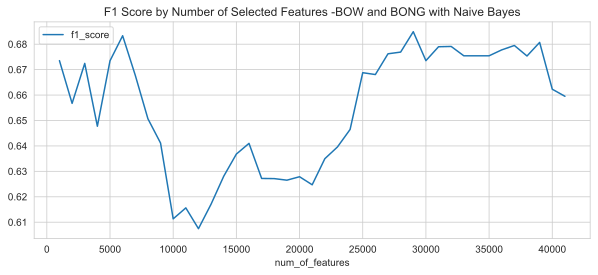

In [79]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [80]:
Opt_no_of_feat = int(sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
Opt_no_of_feat
a = Opt_no_of_feat - 50
b = Opt_no_of_feat + 50
c = 1
print(a, b, c)
sel_nb__bow_bong_df.sort_values(by='f1_score', ascending=False).head(5)

28950 29050 1


,num_of_features,f1_score,accuracy
28,29000,0.68,0.69
5,6000,0.68,0.68
38,39000,0.68,0.68
36,37000,0.68,0.68
31,32000,0.68,0.68


In [81]:
rows = []
for i in range(a, b, c): # range(a, b, c) will count from a to b by intervals of c.    
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_Chi(model_bow_bong, Opt_no_of_feat, x_train_bow_bong, y_train, x_test_bow_bong, y_test)
    rows.append([i, f1_i, accuracy_i])

sel_nb__bow_bong_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

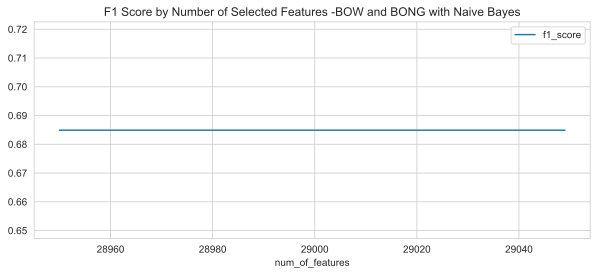

In [82]:
sel_nb__bow_bong_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features -BOW and BONG with Naive Bayes", figsize=(10, 4))

In [83]:
# Save benchmark output
rows_benchmarks.append(["BOW + Bag of NGrams Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", f1_i, accuracy_i])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.68
1,BOW + Bag of NGrams Top: 29000 Features with Naive Bayes,0.68,0.69


## Try PCA Feature Extraction on the BOW Model 

In [88]:
from sklearn.decomposition import PCA

# Define PCA Selection Function
def SelectBestModelFeatures_PCA(model, i,  X_train_pca, y_train_pca, X_test_pca, y_test_pca):
    pca = PCA(n_components=i)
    fit = pca.fit(X_train_pca, y_train_pca)
    ftr_train = fit.transform(X_train_pca)
    ftr_test = fit.transform(X_test_pca)
    #model = GaussianNB()
    cm_nb_pca, pred_nb_pca, f1_nb_pca, report_nb_pca, accuracy_nb_pca = Build_Model(model, ftr_train, y_train, ftr_test, y_test)
    return cm_nb_pca, pred_nb_pca, f1_nb_pca, report_nb_pca, accuracy_nb_pca

In [95]:
# Loop through different no. of component values
model_nb_bow = GaussianNB()
rows = []
for i in range(5, 100, 1): # range(a, b, c) will count from a to b by intervals of c.
    cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_PCA(model_nb_bow, i,  X_train_bow, y_train, X_test_bow, y_test)
    rows.append([i, f1_i, accuracy_i])
acc_df = pd.DataFrame(rows, columns=["num_of_features", "f1_score", "accuracy"])

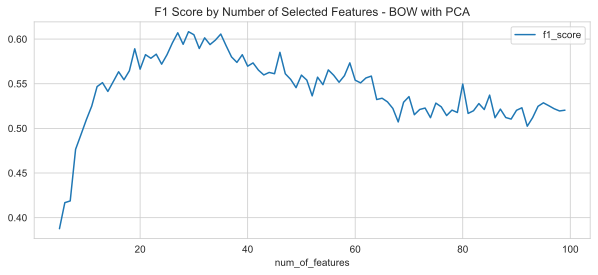

In [96]:
acc_df.plot(x="num_of_features", y="f1_score", title="F1 Score by Number of Selected Features - BOW with PCA", figsize=(10, 4))

In [97]:
Opt_no_of_feat = int(acc_df.sort_values(by='f1_score', ascending=False).iloc[0]['num_of_features'])
print(Opt_no_of_feat)
acc_df.sort_values(by='f1_score', ascending=False).head(5)

29


,num_of_features,f1_score,accuracy
24,29,0.61,0.62
22,27,0.61,0.62
30,35,0.61,0.62
25,30,0.60,0.62
27,32,0.60,0.61


In [98]:
cm_i, pred_i, f1_i, report_i, accuracy_i = SelectBestModelFeatures_PCA(model_nb_bow, Opt_no_of_feat,  X_train_bow, y_train, X_test_bow, y_test)

## Feature Engineering, Extraction and Selection Final Results

In [99]:
# Save benchmark output
rows_benchmarks.append(["BOW With PCA Selection Top: " + str(Opt_no_of_feat) + " Features with Naive Bayes", f1_i, accuracy_i])
df_benchmarks = pd.DataFrame(rows_benchmarks, columns=["Features_Benchedmarked", "f1_score", "accuracy"])
df_benchmarks

,Features_Benchedmarked,f1_score,accuracy
0,BOW Naive Bayes All Features,0.68,0.68
1,BOW + Bag of NGrams Top: 29000 Features with Naive Bayes,0.68,0.69
2,BOW With PCA Selection Top: 28 Features with Naive Bayes,0.57,0.58
3,BOW With PCA Selection Top: 28 Features with Naive Bayes,0.61,0.62
4,BOW With PCA Selection Top: 29 Features with Naive Bayes,0.61,0.62


#### Best results were produced from the BOW Features with optimal Features selected using a Naive Bayes Multinomial Model

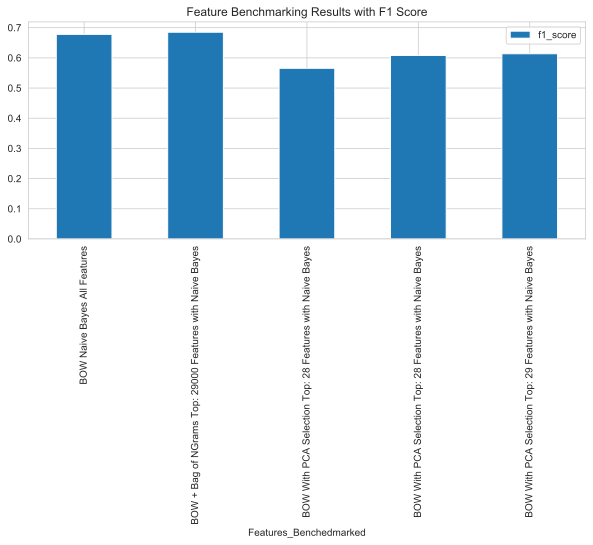

In [100]:
df_benchmarks.plot(x="Features_Benchedmarked", y="f1_score", kind='bar', title="Feature Benchmarking Results with F1 Score", figsize=(10, 4))

#### Confusion Matrix Heat Map of the Predictions fron the Best Resulting Features
#### This gives us a visual on where the model is failing

In [101]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm_opt_bow, annot=True, fmt='d',
            xticklabels=category_id_df.Instruction_id.values, yticklabels=category_id_df.Instruction_id.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

NameError: name 'cm_opt_bow' is not defined